# **Health Insurance Cost**
This project aims to develop a predictive model to estimate insurance charges based on age, sex, BMI, number of children, and smoking habits of an individual.

### Contributors:
- Noah Shore
- Alice Nguyen
- Matthew Bond
- Clover McLaughlin



In [45]:
# Import necessary packages
import os
spark_version = 'spark-3.5.0'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"
# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [46]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Demographics").getOrCreate()

In [47]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://an-project4-12042023.s3.us-east-2.amazonaws.com/insurance.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("insurance.csv"), sep=",", header=True)

# If S3 link doesn't work, please comment out the codes above, upload the csv file to a folder called "data", then uncommend the codes below and re-run this cell
# path = "data/insurance.csv"
# df = spark.read.csv(path, sep=",", header=True)

# Show DataFrame
df.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|    33|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [48]:
# Update datatype
df_updated = df.withColumn("age", df["age"].cast('integer'))
df_updated = df_updated.withColumn("bmi", df_updated["bmi"].cast('float'))
df_updated = df_updated.withColumn("children", df_updated["children"].cast('integer'))
df_updated = df_updated.withColumn("charges", df_updated["charges"].cast('float'))

In [49]:
# Check columns datatype
df_updated.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: float (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: float (nullable = true)



In [50]:
# Convert PySpark DataFrame to Pandas DataFrame
import pandas as pd
pandas_df = df_updated.toPandas()

In [51]:
# Describe our dataset
pandas_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422852
std,14.049960,6.098187,1.205493,12110.010742
min,18.000000,15.960000,0.000000,1121.873901
25%,27.000000,26.296251,0.000000,4740.287109
50%,39.000000,30.400000,1.000000,9382.032715
75%,51.000000,34.693750,2.000000,16639.912109
max,64.000000,53.130001,5.000000,63770.429688


In [52]:
# Check data type
pandas_df.dtypes

age           int32
sex          object
bmi         float32
children      int32
smoker       object
region       object
charges     float32
dtype: object

In [53]:
# Check for null value
null_df = pandas_df.isnull()
null_df.value_counts()

age    sex    bmi    children  smoker  region  charges
False  False  False  False     False   False   False      1338
dtype: int64

# **Identify Potential Outliners**

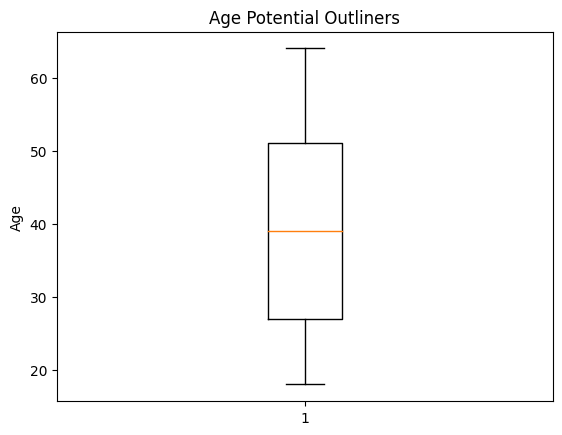

In [54]:
import matplotlib.pyplot as plt

# Create box plot and whisker for column "age"
age = pandas_df['age'].values.tolist()
fig1, ax1 = plt.subplots()
ax1.set_title('Age Potential Outliners')
ax1.set_ylabel('Age')
plt.boxplot(age)
plt.savefig('age.png')
plt.show()

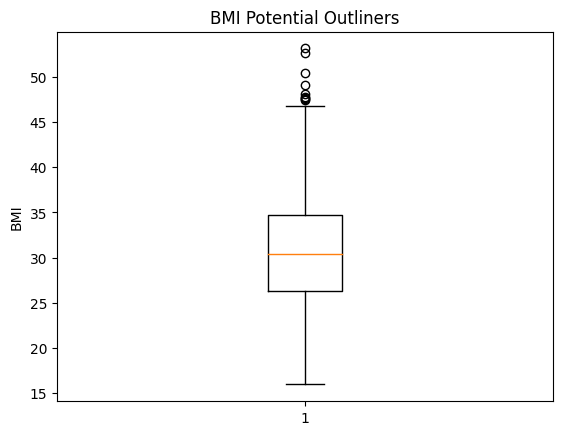

In [55]:
# Create box plot and whisker for column "bmi"
bmi = pandas_df['bmi'].values.tolist()
fig2, ax2 = plt.subplots()
ax2.set_title('BMI Potential Outliners')
ax2.set_ylabel('BMI')
plt.boxplot(bmi)
plt.savefig('bmi.png')
plt.show()

In [56]:
import numpy as np

# Because the box and whisker plot show potential outliers, we use IQR method to define them
quartiles1 = np.quantile(bmi,[.25,.75])
iqr1 = quartiles1[1]-quartiles1[0]
lower_bound1 = quartiles1[0]-(1.5*iqr1)
upper_bound1 = quartiles1[1]+(1.5*iqr1)

bmi_potential_outliers = [value for value in bmi if value < lower_bound1 or value > upper_bound1]
numbers_of_potential_outliners_bmi = len(bmi_potential_outliers)
numbers_of_potential_outliners_bmi

9

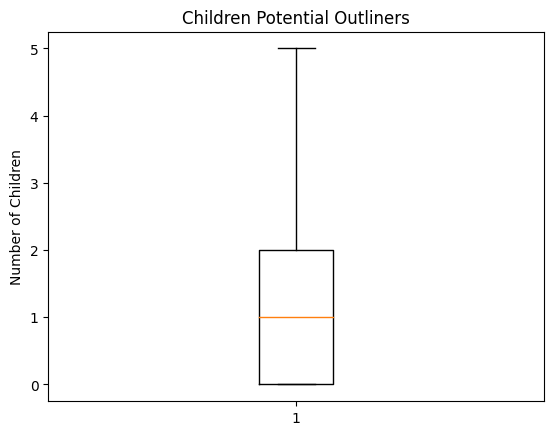

In [57]:
# Create box plot and whisker for column "children"
children = pandas_df['children'].values.tolist()
fig3, ax3 = plt.subplots()
ax3.set_title('Children Potential Outliners')
ax3.set_ylabel('Number of Children')
plt.boxplot(children)
plt.savefig('children.png')
plt.show()

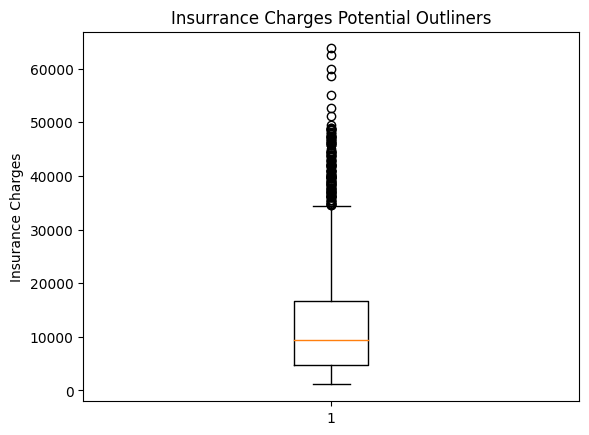

In [58]:
# Create a box plot and whisker for colume "charges"

charges = pandas_df['charges'].values.tolist()
fig1, ax1 = plt.subplots()
ax1.set_title('Insurrance Charges Potential Outliners')
ax1.set_ylabel('Insurance Charges')
plt.boxplot(charges)
plt.savefig('fig1.png')
plt.show()

In [59]:
# Determine which data points are outside of the 1.5*IQR range
quartiles = np.quantile(charges,[.25,.75])
iqr = quartiles[1]-quartiles[0]
lower_bound = quartiles[0]-(1.5*iqr)
upper_bound = quartiles[1]+(1.5*iqr)

potential_outliers = [charge for charge in charges if charge < lower_bound or charge > upper_bound]
numbers_of_potential_outliners = len(potential_outliers)
numbers_of_potential_outliners

139

**Comment**: the "age" and "children" variables exhibited no outliers. However, the “bmi” and "charges" variables, representing bmi and insurance charges, displayed 9 and 139 potential outliers. We believe that these numbers are not genuine outliers; rather, they accurately reflect the reality that a small segment of the population is less healthy than others, leading to significantly higher insurance charges compared to the average.

# **Machine Learning Models**
- Linear Regression
- Random Forest
- Neural Network

### **Linear Regression Model**

In [60]:
#Import Scikit dependencies
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [66]:
# Generate categorical variable list
cat_list = pandas_df.dtypes[pandas_df.dtypes == "object"].index.tolist()
cat_list

['sex', 'smoker', 'region']

In [67]:
#Check the number of unique values in each column
pandas_df[cat_list].nunique()

sex       2
smoker    2
region    4
dtype: int64

In [68]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(pandas_df[cat_list]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(cat_list)
encode_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [69]:
# Merge one-hot encoded features and drop the originals
pandas_df = pandas_df.merge(encode_df,left_index=True, right_index=True)
pandas_df = pandas_df.drop(cat_list,1)
pandas_df.head()

<ipython-input-69-c5a5a8fd4eb0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pandas_df = pandas_df.drop(cat_list,1)


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900000,0,16884.923828,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770000,1,1725.552246,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000000,3,4449.461914,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705000,0,21984.470703,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.879999,0,3866.855225,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [70]:
pandas_df = pandas_df.drop(["sex_male", "smoker_yes"],1)
pandas_df

<ipython-input-70-0f9a715be005>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pandas_df = pandas_df.drop(["sex_male", "smoker_yes"],1)


,age,bmi,children,charges,sex_female,smoker_no,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900000,0,16884.923828,1.0,0.0,0.0,0.0,0.0,1.0
1,18,33.770000,1,1725.552246,0.0,1.0,0.0,0.0,1.0,0.0
2,28,33.000000,3,4449.461914,0.0,1.0,0.0,0.0,1.0,0.0
3,33,22.705000,0,21984.470703,0.0,1.0,0.0,1.0,0.0,0.0
4,32,28.879999,0,3866.855225,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.969999,3,10600.547852,0.0,1.0,0.0,1.0,0.0,0.0
1334,18,31.920000,0,2205.980713,1.0,1.0,1.0,0.0,0.0,0.0
1335,18,36.849998,0,1629.833496,1.0,1.0,0.0,0.0,1.0,0.0
1336,21,25.799999,0,2007.944946,1.0,1.0,0.0,0.0,0.0,1.0


Linear Regression Model 1

In [71]:
#Load the Data
y = pandas_df["charges"].values
X = pandas_df.drop(["charges"],1).values

<ipython-input-71-4c307acc16c0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = pandas_df.drop(["charges"],1).values


In [72]:
#Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1
)

In [74]:
#Create regression model
model = LinearRegression()

In [75]:
#Fit the model
model.fit(X_train, y_train)

LinearRegression()

In [76]:
#Make predictions
predictions = model.predict(X_test)

In [77]:
#Compute the statistics
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

In [78]:
print(f"The r2 score is : {r2}")
print(f"The mean squared error : {mse}")
print(f"The root mean squared: {rmse}")

The r2 score is : 0.7339256422510373
The mean squared error : 35791108.90931643
The root mean squared: 5982.56708356174


In [79]:
print(pandas_df.corr())

                       age       bmi  children   charges  sex_female  \
age               1.000000  0.109272  0.042469  0.299008    0.020856   
bmi               0.109272  1.000000  0.012759  0.198341   -0.046371   
children          0.042469  0.012759  1.000000  0.067998   -0.017163   
charges           0.299008  0.198341  0.067998  1.000000   -0.057292   
sex_female        0.020856 -0.046371 -0.017163 -0.057292    1.000000   
smoker_no         0.025019 -0.003750 -0.007673 -0.787251    0.076185   
region_northeast  0.002475 -0.138156 -0.022808  0.006349    0.002425   
region_northwest -0.000407 -0.135996  0.024806 -0.039905    0.011156   
region_southeast -0.011642  0.270025 -0.023066  0.073982   -0.017117   
region_southwest  0.010016 -0.006205  0.021914 -0.043210    0.004184   

                  smoker_no  region_northeast  region_northwest  \
age                0.025019          0.002475         -0.000407   
bmi               -0.003750         -0.138156         -0.135996   
childr

Linear Regression Model 2

We elimate columns "sex", "children" and "region" because they have very low correlation with our dependent variable "charges" (see correlation matrix above).

In [80]:
#Load the Data
updated_pandas_df = pandas_df[["age", "bmi", "smoker_no", "charges"]]
y = updated_pandas_df["charges"].values
X = updated_pandas_df.drop(["charges"],1).values

<ipython-input-80-b4ad3ac0bc2c>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = updated_pandas_df.drop(["charges"],1).values


In [81]:
#Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1
)

In [82]:
#Create regression model
new_model = LinearRegression()

In [83]:
#Fit the model
new_model.fit(X_train, y_train)

LinearRegression()

In [84]:
#Make predictions
new_predictions = new_model.predict(X_test)

In [85]:
#Compute the statistics
new_r2 = r2_score(y_test, new_predictions)
new_mse = mean_squared_error(y_test, new_predictions)
new_rmse = np.sqrt(mse)

print(f"The r2 score is : {new_r2}")
print(f"The mean squared error : {new_mse}")
print(f"The root mean squared: {new_rmse}")

The r2 score is : 0.7269198531855325
The mean squared error : 36733495.69758316
The root mean squared: 5982.56708356174


**Comment:** After eliminating columns "sex", "children" and "region", the r-square decrease from 0.73 to 0.727. This is a very minimal change. This shows that the 3 variables do not have much impact on our model.

### **Random Forest Model**

**Data Preparation**

In [90]:
from sklearn.model_selection import train_test_split

# Split our preprocessed data into our features and target arrays
y = pandas_df["charges"].values
X = pandas_df.drop(["charges"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

<ipython-input-90-07b8f553ca9e>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = pandas_df.drop(["charges"],1).values


In [91]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [92]:
#Get the prediction data from the random forest model
y_prediction = forest.predict(X_test_scaled)
rf_model = pd.DataFrame(data={"Predicted Premium Amount": y_prediction, "Actual Premium Amount": y_test})
print(rf_model.head())

   Predicted Premium Amount  Actual Premium Amount
0               1549.094270            1646.429688
1              12358.330342           11353.227539
2               9169.990718            8798.592773
3              12019.562700           10381.478516
4               2238.338685            2103.080078


In [93]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#Calculate the root mean squared error
rf_r2 = r2_score(y_test, y_prediction)
rf_mse = mean_squared_error(y_test, y_prediction)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_prediction))

print(f"The r-squared value: {rf_r2}")
print(f"The mean squared error: {rf_mse}")
print(f"The root mean squared error: {rf_rmse}")

The r-squared value: 0.8232897778650338
The mean squared error: 23770253.019982092
The root mean squared error: 4875.474645609604


### **Neural Network Models**

Model 1

In [94]:
import tensorflow as tf
# Define the model
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5

nn_1 = tf.keras.models.Sequential()

# First hidden layer
nn_1.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_1.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_1.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model
nn_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8)                 80        
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                                 
 dense_9 (Dense)             (None, 1)                 6         
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
# Compile the nn model
from keras import Model
from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.losses import MeanSquaredLogarithmicError
from keras.losses import MeanAbsolutePercentageError

msle = MeanSquaredLogarithmicError()

from keras import backend as K
def r2_score(y_test, y_pred):
    SS_res =  K.sum(K.square( y_test-y_pred ))
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nn_1.compile(loss=msle, optimizer="adam", metrics=[r2_score])

In [96]:
# Train the nn model
fit_model = nn_1.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 83.7604 - r2_score: -1.3019
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 83.7206 - r2_score: -1.3205
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 83.5021 - r2_score: -1.2721
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 82.1536 - r2_score: -1.2655
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 78.4798 - r2_score: -1.2750
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 74.1747 - r2_score: -1.2921
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 70.6273 - r2_score: -1.2888
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 67.2208 - r2_score: -1.3393
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 64.0771 - r2_score: -1.3148
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 61.2433 - r2_scor

In [97]:
# Evaluate model 1
nn_1.evaluate(X_test_scaled,y_test,verbose=2)

11/11 - 0s - loss: 11.6277 - r2_score: -1.3794e+00 - 178ms/epoch - 16ms/step


[11.62773609161377, -1.3793643712997437]

Model 2: We add another hidden layer, change the output activation function to linear and increase the number of epochs from 100 to 200

In [98]:
# Define the model
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 5
hidden_nodes_layer3 = 3

nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn_2.summary()

def r2_score(y_test, y_pred):
    SS_res =  K.sum(K.square( y_test-y_pred ))
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nn_2.compile(loss=msle, optimizer="adam", metrics=[r2_score])

fit_model_2 = nn_2.fit(X_train_scaled,y_train,epochs=200)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 80        
                                                                 
 dense_11 (Dense)            (None, 5)                 45        
                                                                 
 dense_12 (Dense)            (None, 3)                 18        
                                                                 
 dense_13 (Dense)            (None, 1)                 4         
                                                                 
Total params: 147 (588.00 Byte)
Trainable params: 147 (588.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
32/32 [==============================] - 1s 2ms/step - loss: 83.7702 - r2_score: -1.3169
Epoch 2/200
32/32 [============================

In [99]:
# Evaluate model 2
nn_2.evaluate(X_test_scaled,y_test,verbose=2)

11/11 - 0s - loss: 83.2235 - r2_score: -1.4598e+00 - 167ms/epoch - 15ms/step


[83.22351837158203, -1.4598002433776855]

Model 3: We add another hidden layer and increase the number of epochs from 200 to 300

In [100]:
# Define the model
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 5
hidden_nodes_layer4 = 3

nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_3.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn_3.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn_3.summary()

def r2_score(y_test, y_pred):
    SS_res =  K.sum(K.square( y_test-y_pred ))
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nn_3.compile(loss=msle, optimizer="adam", metrics=[r2_score])

fit_model_3 = nn_3.fit(X_train_scaled,y_train,epochs=300)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 80        
                                                                 
 dense_15 (Dense)            (None, 8)                 72        
                                                                 
 dense_16 (Dense)            (None, 5)                 45        
                                                                 
 dense_17 (Dense)            (None, 3)                 18        
                                                                 
 dense_18 (Dense)            (None, 1)                 4         
                                                                 
Total params: 219 (876.00 Byte)
Trainable params: 219 (876.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
32/3

In [101]:
# Evaluate model 3
nn_3.evaluate(X_test_scaled,y_test,verbose=2)

11/11 - 0s - loss: 0.1408 - r2_score: 0.6252 - 262ms/epoch - 24ms/step


[0.14082737267017365, 0.6252090334892273]

Model 4: We add another hidden layer and increase the number of epochs from 300 to 400

In [102]:
# Define the model
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 8
hidden_nodes_layer3 = 5
hidden_nodes_layer4 = 5
hidden_nodes_layer5 = 3

nn_4 = tf.keras.models.Sequential()

# First hidden layer
nn_4.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_4.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn_4.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn_4.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))


# Fifth hidden layer
nn_4.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="relu"))

# Output layer
nn_4.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn_4.summary()

def r2_score(y_test, y_pred):
    SS_res =  K.sum(K.square( y_test-y_pred ))
    SS_tot = K.sum(K.square( y_test - K.mean(y_test) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nn_4.compile(loss=msle, optimizer="adam", metrics=[r2_score])

fit_model_4 = nn_4.fit(X_train_scaled,y_train,epochs=400)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 8)                 80        
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dense_21 (Dense)            (None, 5)                 45        
                                                                 
 dense_22 (Dense)            (None, 5)                 30        
                                                                 
 dense_23 (Dense)            (None, 3)                 18        
                                                                 
 dense_24 (Dense)            (None, 1)                 4         
                                                                 
Total params: 249 (996.00 Byte)
Trainable params: 249 

In [103]:
# Evaluate model 4
nn_4.evaluate(X_test_scaled,y_test,verbose=2)

11/11 - 0s - loss: 0.1384 - r2_score: 0.6490 - 248ms/epoch - 23ms/step


[0.13835598528385162, 0.6489566564559937]